In [15]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
#%matplotlib notebook
%config InlineBackend.figure_format = 'retina'


In [79]:
date="20190417"


5441.735375 38985.54141792934


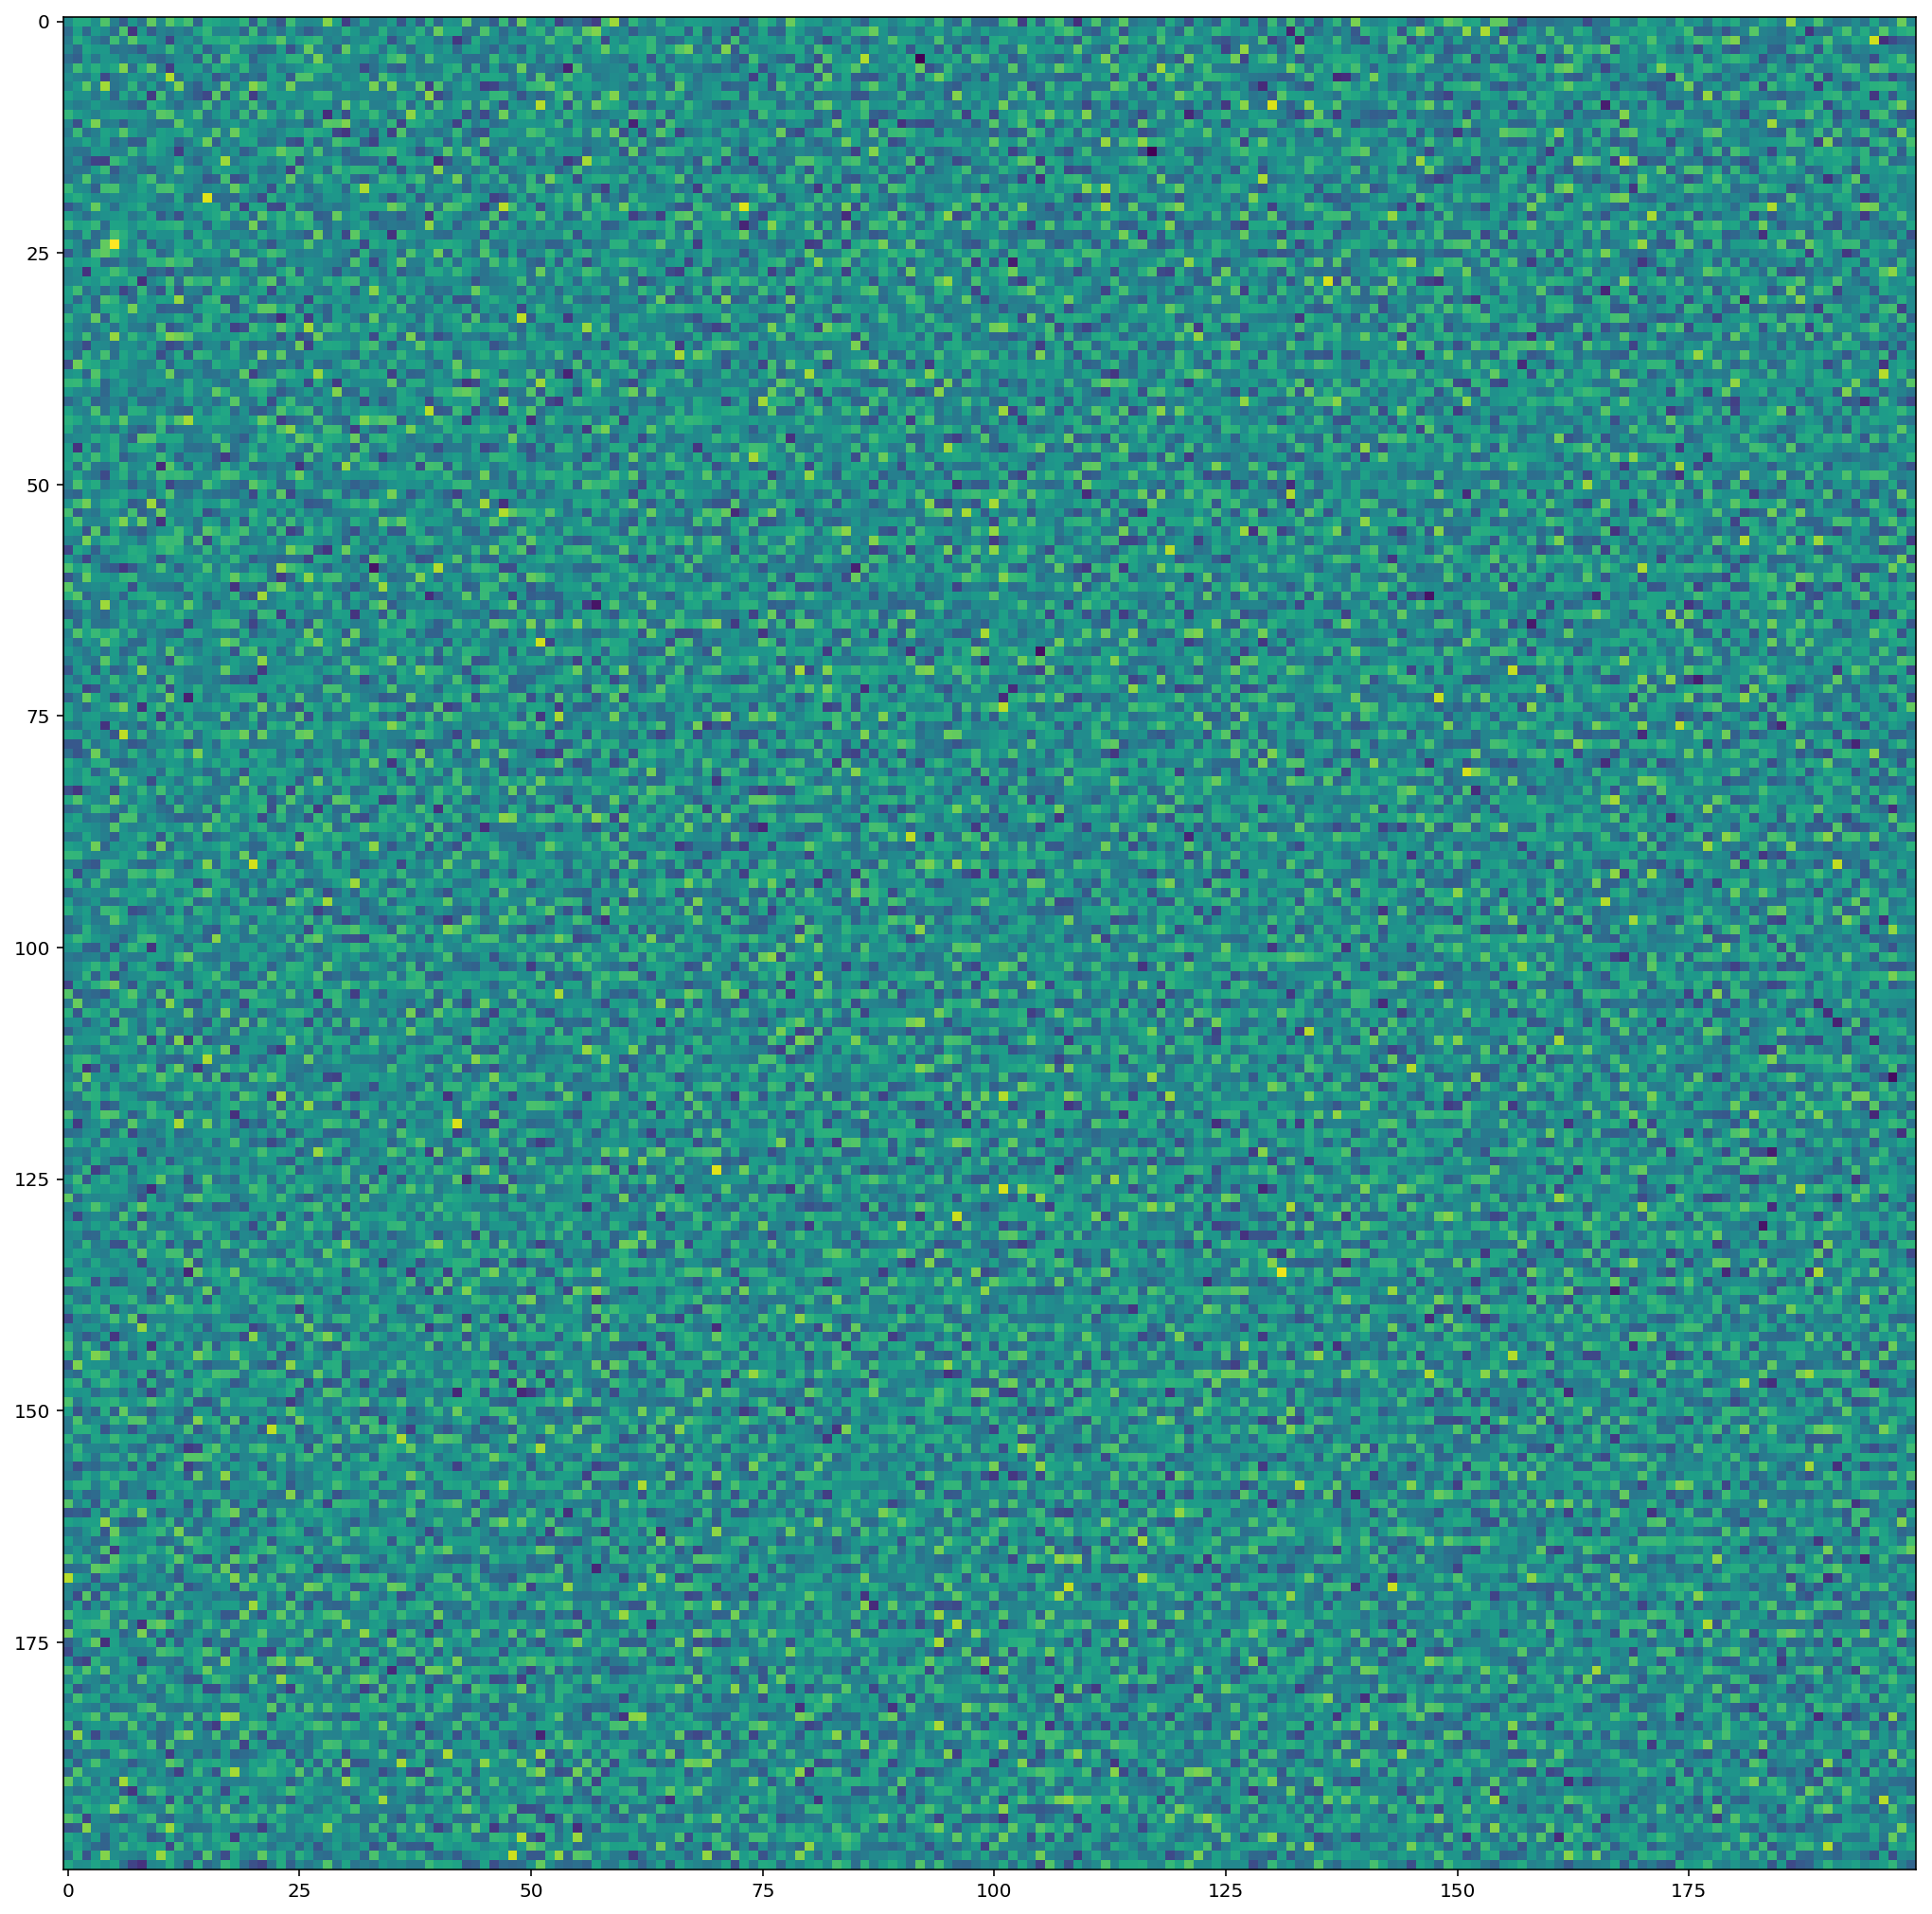

In [94]:
#print(repr(bias[9].header))
xmin=150
xmax=350
ymin=150
ymax=350

expnum=508
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S10.fits"
bias=fits.open(filename)
#print(repr(bas[0].header))

expnum=509
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S10.fits"
flat1=fits.open(filename)

expnum=510
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S10.fits"
flat2=fits.open(filename)

biasamp=bias[6].data[xmin:xmax,ymin:ymax]
flat1amp=flat1[6].data[xmin:xmax,ymin:ymax]
flat2amp=flat2[6].data[xmin:xmax,ymin:ymax]

plt.rcParams['figure.figsize'] = [24, 18]
plt.imshow(flat1amp)
signal=np.mean( flat1amp-biasamp)
variance=np.std( (flat1amp-flat2amp)**2 )

print(signal, variance)

bias.close()
flat1.close()
flat2.close()

In [104]:
date="20190417"
xmin=150
xmax=350
ymin=150
ymax=350
amp=6

signal = []
variance = []


for i in range(487,593,3):
#    print(i)
    biasnum=str(i).zfill(6)
    flat1num=str(i+1).zfill(6)
    flat2num=str(i+2).zfill(6)
    biasfile="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+biasnum+"/CC_C_"+date+"_"+biasnum+"_R22_S10.fits"
    flat1file="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+flat1num+"/CC_C_"+date+"_"+flat1num+"_R22_S10.fits"
    flat2file="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+flat2num+"/CC_C_"+date+"_"+flat2num+"_R22_S10.fits"
    with fits.open(biasfile) as bias:
        biasamp=bias[amp].data[xmin:xmax,ymin:ymax]
    with fits.open(flat1file) as flat1:
        flat1amp=flat1[amp].data[xmin:xmax,ymin:ymax]
#        print(flat1[0].header['EXPTIME'])
    with fits.open(flat2file) as flat2:
        flat2amp=flat2[amp].data[xmin:xmax,ymin:ymax]
    
    signal.append(np.mean( flat1amp - biasamp))
    variance.append(np.std( (flat1amp-flat2amp)**2 ))



[0, 180000, 0, 1250000]

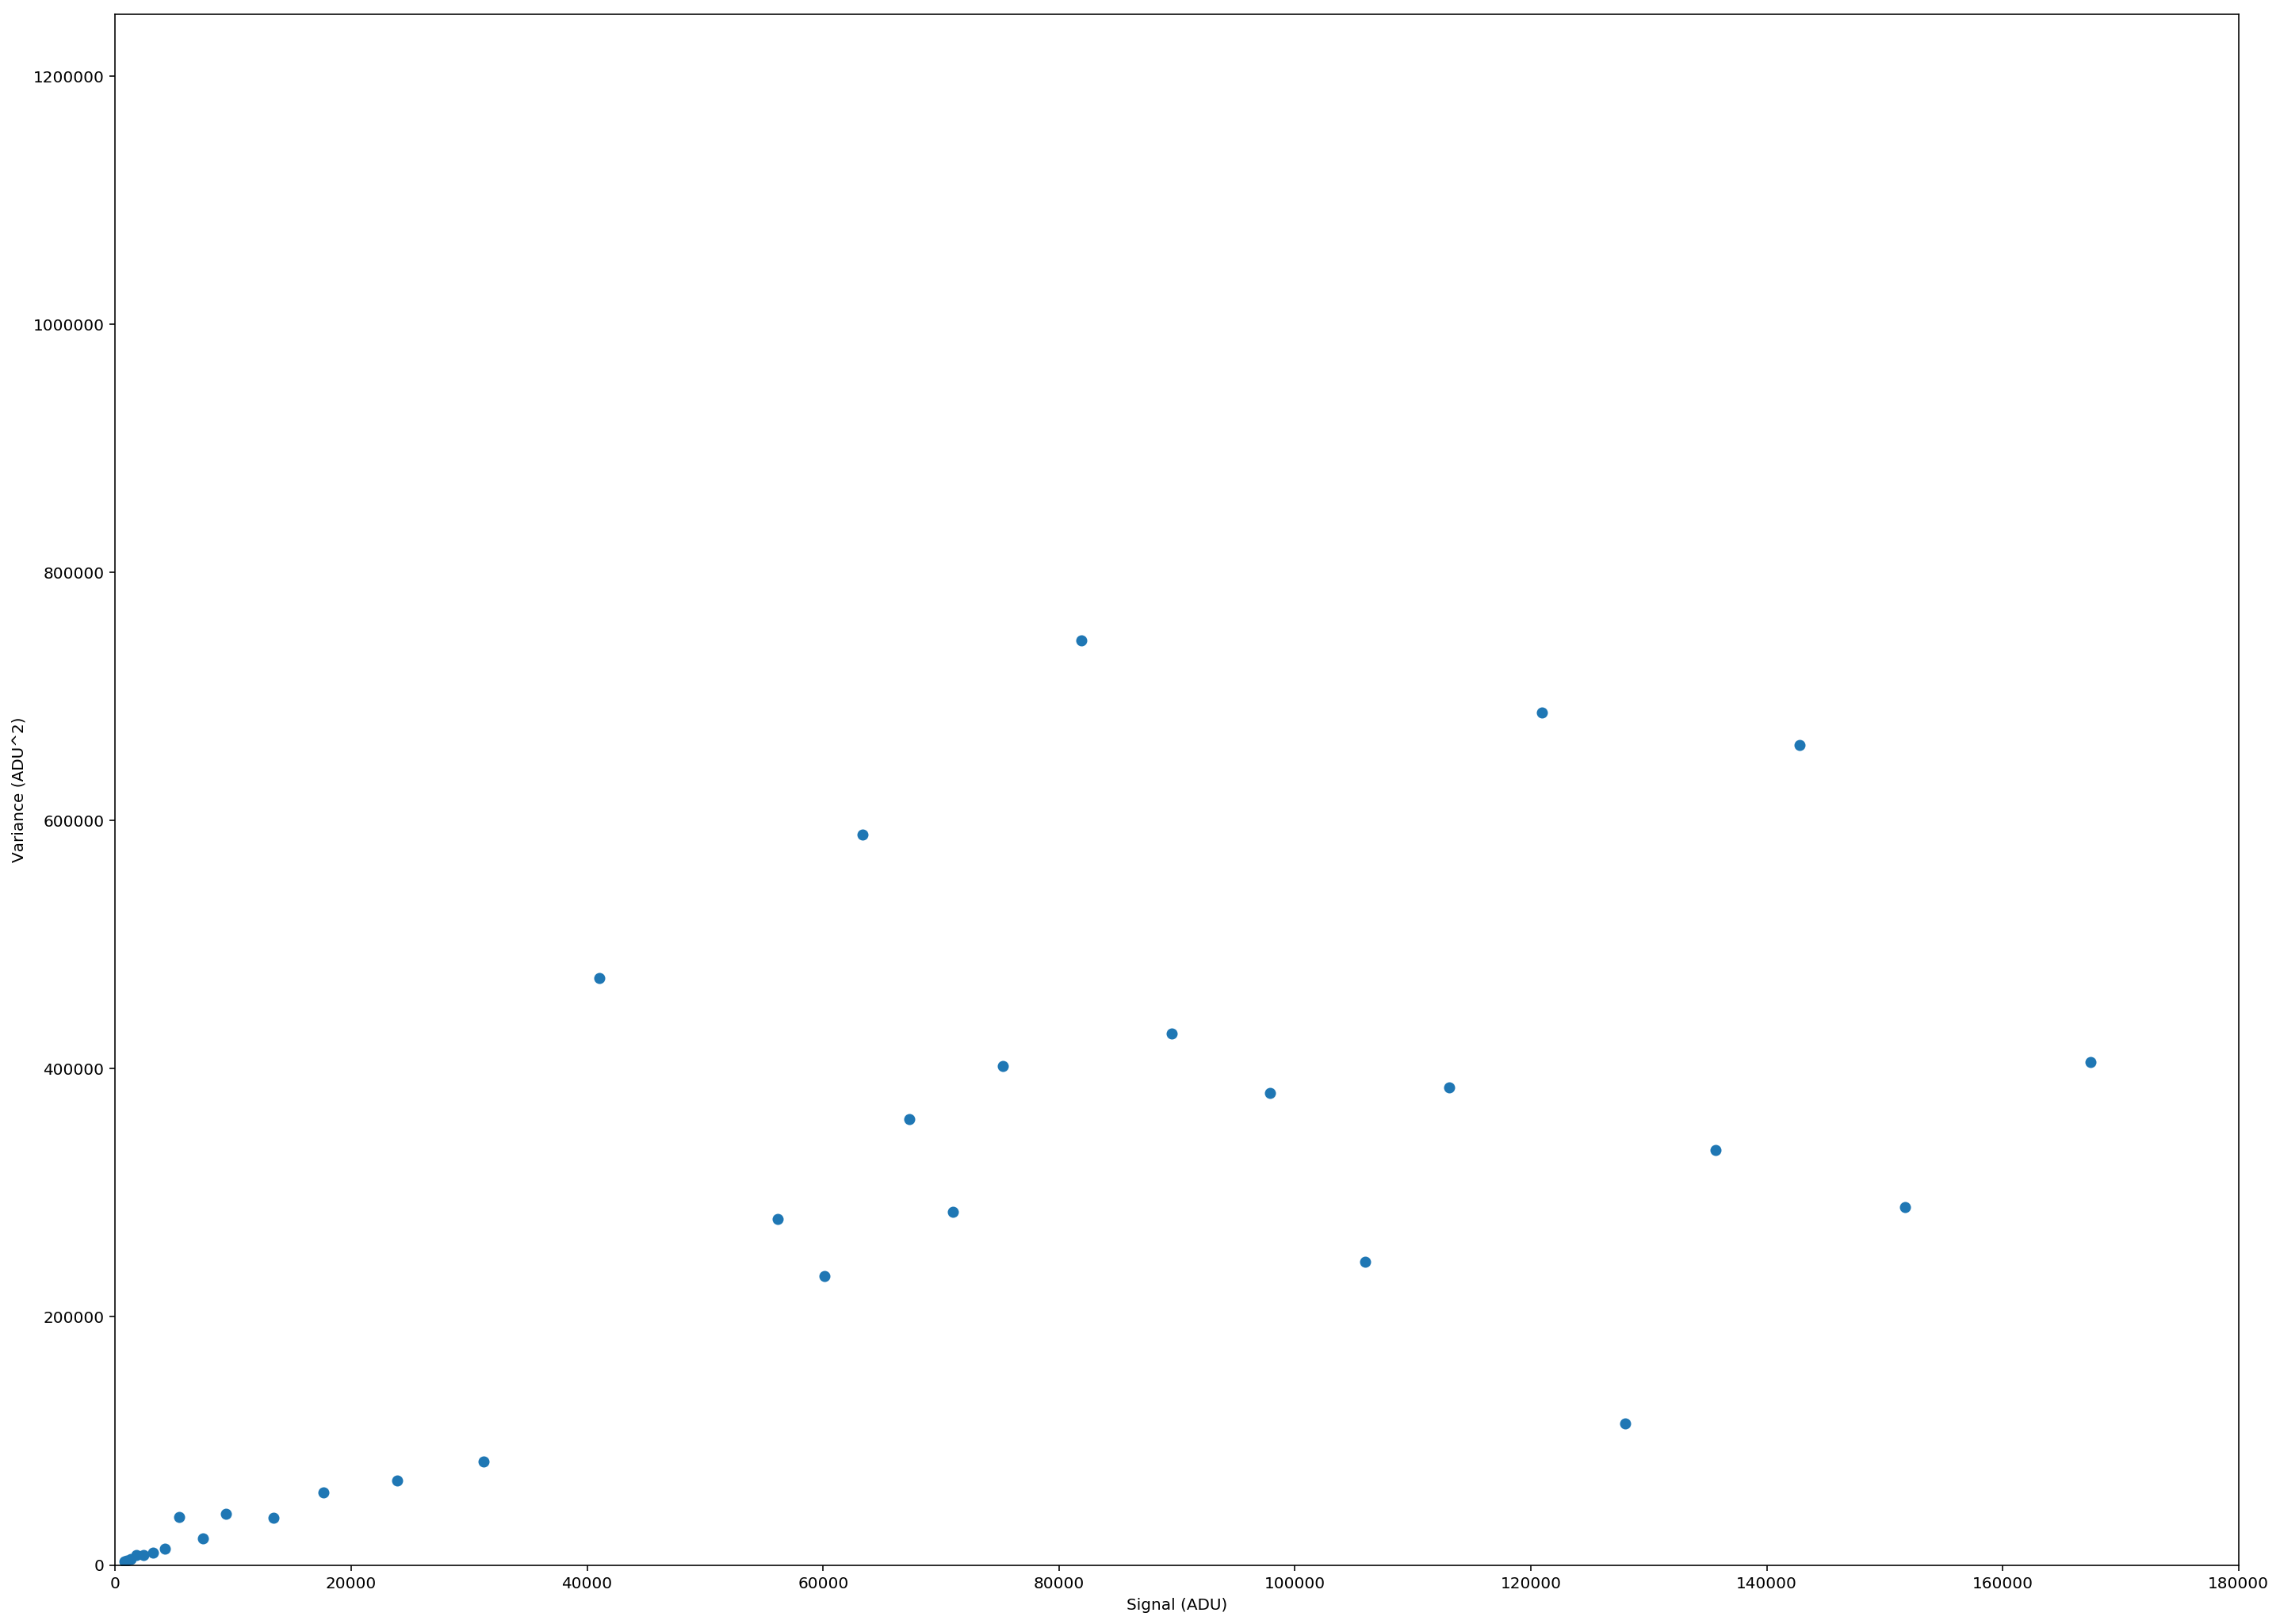

In [105]:
plt.figure()
plt.scatter(signal, variance)
plt.xlabel('Signal (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.axis([0,180000,0,1250000])

In [100]:
for i in range(0,len(signal)-1):
    print(487+3*i,signal[i],variance[i])

487 754.621625 2732.4728889751823
490 981.072425 3417.0588529114684
493 1336.77235 4704.80893792225
496 1786.336225 8234.637030751439
499 2389.40775 7948.226918448127
502 3177.10795 9704.438973244798
505 4192.96325 13043.112321402947
508 5441.735375 38985.54141792934
511 7415.11725 21593.98922572013
514 9409.874125 41368.2186053847
517 13421.662725 38349.24267094571
520 17656.162425 58190.67877017385
523 23873.5878 68203.08974831225
526 31208.633375 83222.75789655896
529 41045.06235 472854.51831031573
532 56136.02945 278748.4980949272
535 60113.813725 233107.70859787974
538 63319.3412 588447.1250441389
541 67327.4381 359340.14170939324
544 71011.762925 284555.542231196
547 75235.29025 402360.8119910724
550 81866.607775 745221.989113479
553 89524.474275 428441.14556612755
556 97921.68715 380590.48369983997
559 105948.518875 244143.12768180092
562 113110.1658 385131.6855857666
565 120929.255375 687267.7606535836
568 128011.880925 114051.16731510288
571 135631.848275 334751.9049949903
574